### Exercise 2 - Numerical Optimization

Consider the following nonlinear optimization problem

<img src="imgs/nlp.png" alt="nlp" width="350"/>


### 2.1 KKT Conditions
Compute the gradients of the objective $f = \frac{1}{2}(x-1)^2 + \frac{1}{2}(10(y - x^2))^2 + \frac{1}{2}x^2$ and the constraints $g = x + (1-y)^2 = 0$ and their Hessian on paper.
Write down on paper the Karush-Kuhn-Tucker (KKT) conditions for the above problem. Are these
conditions necessary for optimality? Are they sufficient?

*.... or write here*

---

Gradient of $f(x, y)$:
$\nabla f(x,y) =
\begin{bmatrix}
    2x -1 - 200 xy + 200 x^3 \\
    100y - 100x^2
\end{bmatrix}$

Hessian of $f(x, y)$:
$\nabla^2 f(x,y) =
\begin{bmatrix}
    2 - 200y + 600 x^2 & -200x \\
     -200 x & 100
\end{bmatrix}$

Gradient of $g(x, y)$:
$\nabla g(x,y) =
\begin{bmatrix}
    1 \\
    -2 + 2y
\end{bmatrix}$

Hessian of $g(x, y)$:
$\nabla^2 g(x,y) =
\begin{bmatrix}
    0 & 0 \\
    0 & 2
\end{bmatrix}$

Lagrangian for this problem: $\mathcal{L}(x,y,\lambda) = f(x,y) + \lambda^\top g(x,y)$, $\lambda \in \mathbb{R}$

KKT conditions (first order necessary conditions):
\begin{align*}
    \nabla_{(x,y)} \mathcal{L}(x^*,y^*,\lambda^*) = \nabla f(x^*,y^*) + \nabla g(x^*,y^*) \lambda^*  &= 0 \\
    g(x^*,y^*) &= 0
\end{align*}

If LICQ holds at $(x^*, y^*)$, the KKT conditions are necessary conditions for optimality, but in general not sufficient.

If the problem is additionally convex, they are also sufficient. The given specific problem is not convex, therefore they are not sufficient.

---

### 2.2 Define the problem with CasADi
Define CasADi functions for $f$ and $g$ and use CasADi to generate the gradient and Hessian functions of these two functions.

In [1]:
import numpy as np
from casadi import SX, vertcat

x = SX.sym('x')
y = SX.sym('y')

z = vertcat(x, y)

f = 0.5 * (x-1)**2 + 0.5 * (10*(y-x**2))**2 + 0.5 * x**2
g = x + (1-y)**2


### 2.3 Solve the problem with `ipopt` and plot the solution
Solve the above constrained optimization problem using CasADi using the solver `IPOPT`.

*Hint: use casadi function `nlpsol`, check its signature in the casadi Docs*

In [2]:
from casadi import nlpsol
solver = nlpsol("solver", "ipopt", {"f": f, "x": z, "g": g})
print(solver)

solver:(x0[2],p[],lbx[2],ubx[2],lbg,ubg,lam_x0[2],lam_g0)->(x[2],f,g,lam_x[2],lam_g,lam_p[]) IpoptInterface


In [3]:
solution = solver(x0=[1, -1], lbg=0, ubg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality c

In [4]:
print(f"{solution=}")
sol_opt = solution["x"]


solution={'f': DM(1.29347), 'g': DM(8.88178e-16), 'lam_g': DM(0.817188), 'lam_p': DM(0x0), 'lam_x': DM([0, 0]), 'x': DM([-0.51811, 0.280202])}


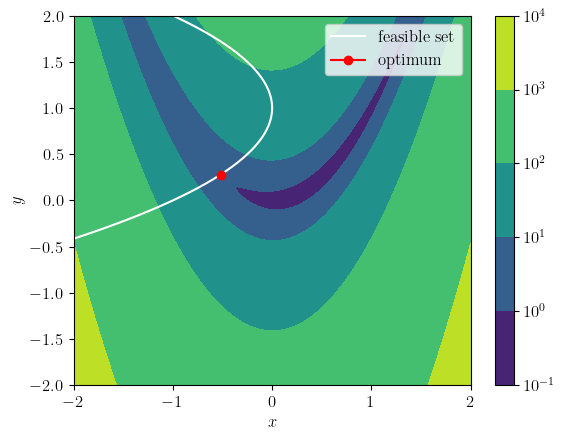

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from acados_template import latexify_plot
latexify_plot()

xlims = (-2, 2)
ylims = (-2, 2)
xs = np.linspace(xlims[0], xlims[1], 500)
ys = np.linspace(ylims[0], ylims[1], 500)
X, Y = np.meshgrid(xs, ys)

Z = 0.5*(X-1)**2 + 0.5*(10*(Y-X**2))**2 + 0.5*X**2

fig, ax = plt.subplots()
CS = ax.contourf(X, Y, Z, locator=ticker.LogLocator())
plt.colorbar(CS)

feasible_x = -(1-ys)**2

plt.plot(feasible_x, ys, color='w', label='feasible set')
plt.plot(sol_opt[0], sol_opt[1], color='r', marker='o', label='optimum')
plt.legend()
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel('$x$')
plt.ylabel('$y$');

Make sure that the KKT conditions are satisfied at the solution that you obtain.

In [6]:
nlp_grad = solver.get_function("nlp_grad")
print(nlp_grad)

nlp_grad:(x[2],p[],lam_f,lam_g)->(f,g,grad_gamma_x[2],grad_gamma_p[]) SXFunction


In [7]:
sol_opt = solution["x"]
lam_g_opt = solution["lam_g"]
print(f"{nlp_grad(sol_opt, [], 1, lam_g_opt)=}")

nlp_grad(sol_opt, [], 1, lam_g_opt)=(DM(1.29347), DM(8.88178e-16), DM([-2.10942e-14, 5.70877e-13]), DM(0x0))


### 2.4 Gentle Introduction to Numerical Optimal Control
We consider the dynamic system of Exercise 1 and now we aim to solve an optimization problem to compute the controls to apply to our system.
The inverted pendulum dynamics is given by:
\begin{equation}
\begin{aligned}
&\dot{\theta} =&& \omega \\
&\dot{\omega} =&& \sin(\theta) + \tau,
\end{aligned}
\end{equation}
where $\theta$ is the angle describing the orientation of the pendulum, $\omega$ is its angular velocity and $\tau$ is the input torque.

**We aim to compute a control trajectory that brings the pendulum in the upward position,** starting from $\bar{\theta} = -\pi$ and $\bar{\omega} = 0$.

<!--
    \begin{equation*}
    \begin{aligned}
    \underset{{{\mathbf{s}, \mathbf{a}}}}{\mathrm{min}} \; \textstyle   \sum_{k=0}^{N-1} &\;  l(s_k, a_k) + e(s_N) \\
    \textrm{s.t.} \quad 
    s_0 &= \bar{s}_0\\
    s_{k+1} &= f(s_k, a_k )  \\
    0 &\geq h(s_k, a_k), \; k = 0, \ldots, N\!-\!1\\
    0 &\geq r(s_N )
    \end{aligned}
    \end{equation*}
 -->

The NLP obtained via direct multiple shooting have the following form:

<img src="imgs/discrete-ocp.png" alt="discrete-ocp" width="350"/>



In order we will:
- Define the ODE
- Create a RK4 integrator to discretize the dynamics
- Define a quadratic stage cost for the optimal control problem
- Formulate a direct multiple shooting problem in CasADi
- Solve the problem with `ipopt`

In [8]:
from casadi import SX, sin, Function, inf
import numpy as np

In [9]:
# continuous model dynamics
n_s = 2  # number of states
n_a = 1  # number of actions

theta = SX.sym('theta')
omega = SX.sym('omega')
tau = SX.sym('tau')

# FILL IN YOUR CODE HERE
theta_dot = omega
omega_dot = sin(theta) + tau

s = vertcat(theta, omega)
s_dot = vertcat(theta_dot, omega_dot)

In [10]:
def integrate_RK4(s_expr, a_expr, sdot_expr, dt, N_steps=1):
    '''RK4 integrator.

    s_expr, a_expr: casadi expression that have been used to define the dynamics sdot_expr
    sdot_expr:      casadi expr defining the rhs of the ode
    dt:             integration interval
    N_steps:        number of integration steps per integration interval, default:1
    '''

    h = dt/N_steps

    s_end = s_expr

    sdot_fun = Function('xdot', [s_expr, a_expr], [sdot_expr])

    for _ in range(N_steps):

    # FILL IN YOUR CODE HERE
        v_1 = sdot_fun(s_end, a_expr)
        v_2 = sdot_fun(s_end + 0.5 * h * v_1, a_expr)
        v_3 = sdot_fun(s_end + 0.5 * h * v_2, a_expr)
        v_4 = sdot_fun(s_end + v_3 * h, a_expr)
        s_end += (1/6) * (v_1 + 2 * v_2 + 2 * v_3 + v_4) * h

    F_expr = s_end

    return F_expr

The stage cost should have the following form
\begin{equation}
    l(x, u) = \frac{1}{2} \left( x^\top Q x + u^\top R u \right)
\end{equation}
and the terminal cost
\begin{equation}
    e(x) = \frac{1}{2} \left( x^\top Q x \right)
\end{equation}
with
\begin{equation}
    Q = \begin{bmatrix} 10 & 0 \\ 0 & 1 \end{bmatrix}
\end{equation}
and
\begin{equation}
    R = \begin{bmatrix} 1 \end{bmatrix}
\end{equation}
**Discretize the stage cost with explicit Euler:** $\int_{t_i}^{t_{i+1}}l(x(t), u(t))dt \approx (t_{i+1} - t_i) \cdot l(x(t_i), u(t_{i}))$.

In [11]:
# Define number of steps in the control horizon and discretization step
N = 200
delta_t = 1/20
# Define RK4 integrator function and initial state x0_bar
F_rk4 = Function("F_rk4", [s, tau], [integrate_RK4(s, tau, s_dot, delta_t)])
x0_bar = [np.pi, 0]

# Define the weighting matrix for the cost function
Q = np.eye(n_s)
Q[0,0] = 10
R = np.eye(n_a)

We want to constrain the action such that $\tau \in [-1, 1]$ and state such that $\theta \in [-\pi/2, 2\pi]$ while $\omega$ is free.

To enforce constraint on the optimization variables directly (as box constraint) we can use CasADi `lbw, ubw`.

*Hint 1: enforce the initial state by setting the* `lbw, ubw` *corresponding to the $s_0$ variable to $\bar{s}_0$.*

For enforcing generic constraint, we first define them as CasADi expression in `g` and then assign the respective lower and upper bound via `lbg, ubg`. 

*Hint 2: this is what we need to do for defining the multiple shooting constraints.*



In [12]:
# Start with an empty NLP
w = []
w0 = []
lbw = []
ubw = []
J = 0
g = []
lbg = []
ubg = []

# "Lift" initial conditions
Xk = SX.sym('X0', 2)
w += [Xk]
lbw += x0_bar    # set initial state
ubw += x0_bar    # set initial state
w0 += x0_bar     # set initial state

# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = SX.sym('U_' + str(k))
    w   += [Uk]
    lbw += [-1]
    ubw += [1]
    w0  += [0]

    # Integrate till the end of the interval
    Xk_end = F_rk4(Xk, Uk)
    J = J + delta_t * 1/2 * (Xk.T @ Q @ Xk + R * Uk**2) # Complete with the stage cost

    # New NLP variable for state at end of interval
    Xk = SX.sym(f'X_{k+1}', 2)
    w += [Xk]
    lbw += [-np.pi/2, -inf]
    ubw += [2*np.pi, inf]
    w0 += [0, 0]

    # Add equality constraint to "close the gap" for multiple shooting
    g   += [Xk_end-Xk]
    lbg += [0, 0]
    ubg += [0, 0]
J = J + 1/2 * (Xk.T @ Q @ Xk) # Complete with the terminal cost (NOTE it should be weighted by delta_t)

# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1596
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1197

Total number of variables............................:      600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4674011e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Retrieve the state and action trajectories and plot them.

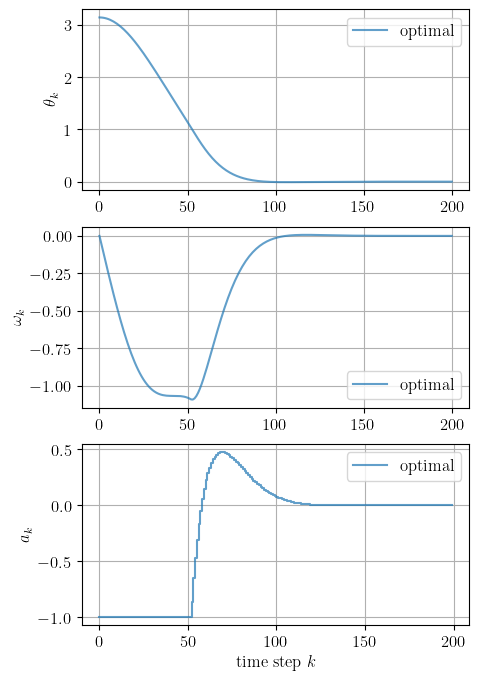

In [13]:
from plot_utils import plot_trajectories
s_traj_opt = np.vstack((w_opt[::3], w_opt[1::3]))
a_traj_opt = w_opt[2::3][np.newaxis, ...]
plot_trajectories(s_traj_opt, a_traj_opt, labels='optimal')
